In [1]:
!pip install tomotopy

In [2]:
from gensim.models.coherencemodel import CoherenceModel
import tomotopy as tp
import csv
import matplotlib.pyplot as plt

ldamodel = tp.LDAModel

First we will import the preprocessed tokens.

In [3]:
preprocessed_collection = []

with open('data/tokens_20k.csv', 'r', newline='') as file:
  myreader = csv.reader(file, delimiter=',')
  for row in myreader:
    preprocessed_collection.append(row)

In [4]:
find_hyperparameters =  False

In [5]:
if find_hyperparameters:
    rm_top =[10, 20, 30, 40] #the number of top words to be removed (default 0)
    min_df = [0, (int) (len(preprocessed_collection) * 0.005),(int) (len(preprocessed_collection) * 0.01), (int) (len(preprocessed_collection) * 0.02), (int) (len(preprocessed_collection) * 0.02)] #minimum document frequency of words (default 0)
    min_cf = [0, 10, 20, 30, 50, 100, 200, 300] #minimum collection frequency of words. (default 0)
    alphas = [0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05] #hyperparameter of Dirichlet distribution for document-topic (default 0.1)
    etas = [0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05]  #hyperparameter of Dirichlet distribution for topic-word (default 0.01)
    K=[10, 20, 30, 40, 50]
    iterations = len(rm_top) * len(min_df) * len(min_cf) * len(alphas) * len(etas) * len(K)
    cv=[]
    iter = 0
    configs = []
    print('# of docs:', len(preprocessed_collection)) 
    print('# of iterations:', iterations)
    for k in K:
      for mdf in min_df:
        for rm in rm_top:
          for a in alphas: 
            for e in etas:
              for mcf in min_cf:
                iter += 1
                print(iter, end=' ')
                #create an object
                #tw term weight IDF (Inverse Document Frequency term weighting), ONE (equal - default), PMI (Use Pointwise Mutual Information term weighting)
                LDA = ldamodel(tw = tp.TermWeight.IDF, k=k, alpha = a , eta = e, seed = 9999,  min_df = mdf, min_cf = mcf, rm_top = rm)
                #add documents to it
                for doc in preprocessed_collection:
                    LDA.add_doc(doc)
                #train
                LDA.train(iter = 500) # iter (# of iterations - default 10) # workers (# of cores to be used - 0 all)
                #get the coherence (c_v)
                coh = tp.coherence.Coherence(LDA, coherence='c_v')
                average_coherence = coh.get_score()
                print('K: %2d mcf: %2d mdf: %2d rm: %2d alfa: %.3f beta: %.3f coherence: %.3f'%(k,mcf,mdf,rm,a,e,average_coherence),end=' Collection ')
                print(' Vocab size:', len(LDA.used_vocabs), ' # of words:', LDA.num_words)
                configs.append([k,mcf,mdf,rm,a,e,average_coherence])
                cv.append(average_coherence)

## Create model

In [6]:
rm_top = 10
min_df = 194
min_cf = 194
alpha = 0.2
eta = 0.1
K = 20

LDA = ldamodel(
    tw = tp.TermWeight.IDF,
    k=K, alpha = alpha, 
    eta = eta,
    seed = 9999,
    min_df = min_df,
    min_cf = min_cf,
    rm_top = rm_top
)
for doc in preprocessed_collection:
    LDA.add_doc(doc)

LDA.train(iter = 500) 

/tmp/ipykernel_46580/205317636.py:20: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  LDA.train(iter = 500)


In [7]:
coh = tp.coherence.Coherence(LDA, coherence='c_v')
av_co = coh.get_score()
print("\nCoherence:", av_co)


Coherence: 0.7594939216971398


In [8]:
LDA.summary()

<Basic Info>
| LDAModel (current version: 0.12.3)
| 19476 docs, 2817094 words
| Total Vocabs: 193656, Used Vocabs: 2795
| Entropy of words: 7.45066
| Entropy of term-weighted words: 7.71646
| Removed Vocabs: year people time like new good way day government week
|
<Training Info>
| Iterations: 500, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -7.74652
|
<Initial Parameters>
| tw: TermWeight.IDF
| min_cf: 194 (minimum collection frequency of words)
| min_df: 194 (minimum document frequency of words)
| rm_top: 10 (the number of top words to be removed)
| k: 20 (the number of topics between 1 ~ 32767)
| alpha: [0.2] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.1 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 9999 (random seed)
| trained in version 0.12.3
|
<Parameters>
| alpha (Dirichlet prior on

In [9]:
print("\n** Topics **\n")
for i in range(K):
  print("Topic", i, end=' => ')
  for w in LDA.get_topic_words(i):
    print(w[0], end=' ')
  print()



** Topics **

Topic 0 => film bbc movie actor comedy character episode series star hollywood 
Topic 1 => market economy price company growth business bank industry sale investment 
Topic 2 => apple company facebook app user online google technology digital internet 
Topic 3 => song music album band festival artist sound pop track singer 
Topic 4 => school student child university community council education housing work young_people 
Topic 5 => police court case prison law investigation officer australia report inquiry 
Topic 6 => labour corbyn party labour_party jeremy_corbyn election leader member labour_leader general_election 
Topic 7 => game player team england sport match race season ball coach 
Topic 8 => company business tax bank money customer worker deal firm payment 
Topic 9 => police isis attack city syria camp war family refugee gun 
Topic 10 => art artist theatre museum work play exhibition painting london gallery 
Topic 11 => trump clinton election donald_trump candidat

In [10]:
topics_dist = [(x, 0) for x in range(K)]
topics_docs = [[] for x in range(K)]
c = 0
for index, doc in enumerate(LDA.docs):
  threshold = 0.3

  d_topics = doc.get_topics(top_n=4)
  found_topic = False;

  for topic in d_topics:
    if topic[1] >= threshold:
      ntd = topics_dist[topic[0]][1] + 1
      topics_dist[topic[0]] = (topic[0], ntd)
      topics_docs[topic[0]].append(index)
      found_topic = True    
    
  if not found_topic:
    ntd = topics_dist[d_topics[0][0]][1] + 1
    topics_dist[d_topics[0][0]] = (d_topics[0][0], ntd) 

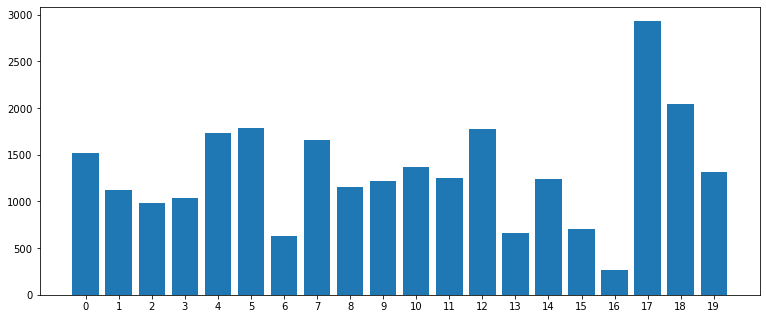

In [11]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_axes([0,0,1,1])
topics = [str(x) for x in range(K)]
documents = [y for (x, y) in topics_dist]
ax.bar(topics, documents)
plt.show()

In [12]:
topics_dist = sorted(topics_dist, reverse=True, key=lambda x: x[1])

print("\n** Sorted Topics **\n")

for topic in topics_dist:
  print("Topic", topic[0], end=' => ')
  for w in LDA.get_topic_words(topic[0]):
    print(w[0], end=' ')
  print()


** Sorted Topics **

Topic 17 => child thing life friend mother family man parent father woman 
Topic 18 => book woman novel story writer man word life black author 
Topic 5 => police court case prison law investigation officer australia report inquiry 
Topic 12 => brexit britain europe referendum country prime_minister european british cameron vote 
Topic 4 => school student child university community council education housing work young_people 
Topic 7 => game player team england sport match race season ball coach 
Topic 0 => film bbc movie actor comedy character episode series star hollywood 
Topic 10 => art artist theatre museum work play exhibition painting london gallery 
Topic 19 => club player game team football season goal manager premier_league liverpool 
Topic 11 => trump clinton election donald_trump candidate labor obama president sanders hillary_clinton 
Topic 14 => water food city island restaurant garden town tree park hotel 
Topic 9 => police isis attack city syria ca

Topic 17 => child thing life friend mother family man parent father woman (Family)

Topic 18 => book woman novel story writer man word life black author (Books)

Topic 5 => police court case prison law investigation officer australia report inquiry (Police Cases)

Topic 12 => brexit britain europe referendum country prime_minister european british cameron vote (United Kingdom News)

Topic 4 => school student child university community council education housing work young_people (Young People)

Topic 7 => game player team england sport match race season ball coach (Sports)

Topic 0 => film bbc movie actor comedy character episode series star hollywood (Entertainment)

Topic 10 => art artist theatre museum work play exhibition painting london gallery (Art)

Topic 19 => club player game team football season goal manager premier_league liverpool (Soccer)

Topic 11 => trump clinton election donald_trump candidate labor obama president sanders hillary_clinton (Politics)


In [13]:
LDA.docs[topics_docs[5][20]] # PoliceCases Topic Example

<tomotopy.Document with words="family detention_center outside texas license family detention_center outside texas license immigrant right_activist berks_county residential_center pennsylvania license license letter berks_county week pennsylvania_department human_services center license child residential_facility license center february letter state certificate compliance november facility february state approval expansion bed_bed warning year county huge development bridget_cambria partner cambria kline law_firm client berks proud state will family detention cambria detainee young day old facility contract immigration_customs enforcement_ice parent_child room unrelated adult fence facility old hospital free ice parent_child residential_center low security_measure place detention_center adult berks unique father_mother child family_berks ice_raid early_month cambria client facility long month appeal spouse relative asylum fear torture persecution home country ice facility model woman c

In [14]:
LDA.docs[topics_docs[7][100]] # Sports Topic Example

<tomotopy.Document with words="mitchell_pearce likely nrl suspension wil sydney_roosters hard nick_tedeschi sydney_roosters star mitchell_pearce late behavioural indiscretion likely suspension nrl major reverberation rugby_league world league little choice pearce significant time precedent stone fate todd_carney blake_ferguson recent_year pearce suspension likely year indefinite ferguson season criminal_charge carney seemingly black nrl series distasteful incident currently legal_action club cronulla case likely great pearce_club straight minor_premiership nrl title club disarray practical sense troubling roosters premiership favourite likely season half combination jackson hastings jayden nikorima grand total nrl game bookmaker rightly premiership roosters big drifter hastings player immense_promise tender_age likely gradually action support experienced pearce_likely senior half having game season roosters decision origin star james_maloney defect sharks nikorima sniff grade broncos r

In [15]:
LDA.docs[topics_docs[11][11]] # Politics Topic Example

<tomotopy.Document with words="obama true_heir hillary_clinton blessing bernie_sanders kim phillips fein past week iowa_caucus nigh debate democratic_party circle legacy president_barack obama_hillary clinton senator_bernie sanders legacy clinton_campaign website candidate recently letter supporter president_obama legacy means campaign term record financial_regulation healthcare foreign_policy role administration onetime political_opponent reader place colleague confidante sanders rhetoric political transformation obama clearly clinton_iowa young_people way obama year_ago candidate understandably stamp obama approval true sanders obama term voter usually poll similarity obama sanders_clinton obama_legacy legacy sanders_sanders obama_heir campaign crisis middle_class era inequality problem past_year term policy campaign proposal genuine departure promise health_insurance truly universal commitment system free public high_education attempt building_block economic security vagary marketpl

In [18]:
LDA.docs[topics_docs[19][12]]

<tomotopy.Document with words="chelsea_manchester city arsenal_hull cup_round manchester_city chelsea_stamford bridge cup_round club meet having city chelsea competition occasion chelsea dons shortly draw place game club_captain john_terry season contract_stamford bridge shrewsbury_town currently league manchester_united good run competition time winner fellow tier peterborough reading round_replay west_brom holder arsenal_hull city emirates club final_wembley current championship leader premier_league tie tottenham meeting crystal_palace everton trip bournemouth_round match place february cup_round draw_chelsea manchester_city west_brom peterborough watford leeds_united shrewsbury_town manchester_united blackburn_rovers liverpool west_ham united_tottenham crystal_palace arsenal_hull city bournemouth_everton">